# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [13]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [14]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"
output_dir = "./Output"
model_dir = "./Models"
test_data_path = f"{data_dir}/Xtest.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "GRU_WITH_DROPOUT"
model_pth_path = f"{model_dir}/best_model_{model_name}.pth"
random.seed(42)

In [15]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [16]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step(avg_val_mae_loss)

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Gated recurrent units (GRUs) RNN Model

In [17]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.dropout= nn.Dropout(dropout) if num_stacked_layers > 1 else 0.0

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


### Load and Split the dataset into train-validation

In [18]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

# load the test data
test_data = loadmat(test_data_path)
test_measurements = test_data['Xtest']
print("Shape of test measurements:", test_measurements.shape)
print(f"test_measurements range: min={test_measurements.min()}, max={test_measurements.max()}")
test_data_normalized = scaler.transform(test_measurements)
print(f"test_data_normalized range: min={test_data_normalized.min()}, max={test_data_normalized.max()}")
test_dataset = test_data_normalized


Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=0.03952569169960474, max=0.6996047430830039
Shape of test measurements: (200, 1)
test_measurements range: min=3, max=255
test_data_normalized range: min=0.003952569169960474, max=1.0


### Training the Model 

In [19]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 128, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 7, 20, step=1)
    dropout = trial.suggest_float('dropout', 0.1, 0.3, step=0.1) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = GRU(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size,
        num_stacked_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"{output_dir}/all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = GRU(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers'],
    dropout = study.best_params['dropout']
).to(device)
best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-09 10:01:56,977] A new study created in memory with name: no-name-56bd06be-5d3c-47b2-9021-2bc4ed10e264


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_6796\104061367.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-09 10:02:20,267] Trial 0 finished with value: 0.1345830038189888 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 1.4091693343052576e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.2}. Best is trial 0 with value: 0.1345830038189888.


Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:02:29,127] Trial 1 finished with value: 0.13303805142641068 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 1.3769635737010588e-05, 'batch_size': 128, 'window_size': 9, 'dropout': 0.3}. Best is trial 1 with value: 0.13303805142641068.


Best model saved with trial 1


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:03:01,861] Trial 2 finished with value: 0.03578699007630348 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 4.5777961525314494e-05, 'batch_size': 32, 'window_size': 9, 'dropout': 0.2}. Best is trial 2 with value: 0.03578699007630348.


Best model saved with trial 2


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:03:35,871] Trial 3 finished with value: 0.054673407692462206 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 1.7719830238679066e-05, 'batch_size': 32, 'window_size': 12, 'dropout': 0.2}. Best is trial 2 with value: 0.03578699007630348.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:03:53,544] Trial 4 finished with value: 0.052657573483884335 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 4.0221709080579904e-05, 'batch_size': 64, 'window_size': 19, 'dropout': 0.3}. Best is trial 2 with value: 0.03578699007630348.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:04:08,515] Trial 5 finished with value: 0.006441083969548345 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.00021740364134141999, 'batch_size': 128, 'window_size': 20, 'dropout': 0.2}. Best is trial 5 with value: 0.006441083969548345.


Best model saved with trial 5


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:04:44,795] Trial 6 finished with value: 0.050157974706962705 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 2.524388075449364e-05, 'batch_size': 32, 'window_size': 9, 'dropout': 0.1}. Best is trial 5 with value: 0.006441083969548345.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:05:07,610] Trial 7 finished with value: 0.006167770712636411 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.00022039940556762945, 'batch_size': 64, 'window_size': 12, 'dropout': 0.1}. Best is trial 7 with value: 0.006167770712636411.


Best model saved with trial 7


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:05:19,643] Trial 8 finished with value: 0.003963747818488628 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0016317145648814403, 'batch_size': 64, 'window_size': 17, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 65 epochs.
Best model saved with trial 8


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:05:37,672] Trial 9 finished with value: 0.04195663332939148 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 6.935449588454554e-05, 'batch_size': 64, 'window_size': 11, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:05:48,553] Trial 10 finished with value: 0.00444480637088418 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00702101340860266, 'batch_size': 64, 'window_size': 16, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 60 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:05:52,336] Trial 11 finished with value: 0.014274436165578663 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.006993868412701007, 'batch_size': 64, 'window_size': 16, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 21 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:00,022] Trial 12 finished with value: 0.005813884665258229 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.004835642128486054, 'batch_size': 64, 'window_size': 16, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 43 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:06,830] Trial 13 finished with value: 0.005975569016300142 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0017990982721253486, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 35 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:13,362] Trial 14 finished with value: 0.004580761305987835 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.001330068286580006, 'batch_size': 128, 'window_size': 14, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 61 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:22,129] Trial 15 finished with value: 0.005551161477342248 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0017146709783202132, 'batch_size': 64, 'window_size': 17, 'dropout': 0.2}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 55 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:32,023] Trial 16 finished with value: 0.008310987730510533 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0006739749960414478, 'batch_size': 64, 'window_size': 14, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 52 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:51,508] Trial 17 finished with value: 0.004784040269441903 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.009533029385203961, 'batch_size': 64, 'window_size': 15, 'dropout': 0.3}. Best is trial 8 with value: 0.003963747818488628.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:06:56,557] Trial 18 finished with value: 0.00842861132696271 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.003513837442603753, 'batch_size': 128, 'window_size': 7, 'dropout': 0.1}. Best is trial 8 with value: 0.003963747818488628.


Early stopping triggered after 59 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:07:30,528] Trial 19 finished with value: 0.005068526923423633 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0006296130880442787, 'batch_size': 32, 'window_size': 18, 'dropout': 0.2}. Best is trial 8 with value: 0.003963747818488628.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:07:42,760] Trial 20 finished with value: 0.0038384138024412096 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0033924708966717055, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 20 with value: 0.0038384138024412096.


Early stopping triggered after 63 epochs.
Best model saved with trial 20


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:08:02,044] Trial 21 finished with value: 0.0041274294489994645 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.003225145468893534, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 20 with value: 0.0038384138024412096.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:08:21,232] Trial 22 finished with value: 0.003626495017670095 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0031287465165710285, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 97 epochs.
Best model saved with trial 22


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:08:41,126] Trial 23 finished with value: 0.0038727091159671545 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0008616654665912171, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:09:01,178] Trial 24 finished with value: 0.0037319959374144673 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0006694196550466973, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:09:09,554] Trial 25 finished with value: 0.009601427940651774 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.000339197204500374, 'batch_size': 64, 'window_size': 19, 'dropout': 0.2}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 43 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:09:15,081] Trial 26 finished with value: 0.011873657815158367 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.002638965888207023, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 22 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:09:32,471] Trial 27 finished with value: 0.011888775508850813 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0004253178385722987, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:09:47,544] Trial 28 finished with value: 0.04801050201058388 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 9.353926988452715e-05, 'batch_size': 128, 'window_size': 20, 'dropout': 0.2}. Best is trial 22 with value: 0.003626495017670095.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:09:58,351] Trial 29 finished with value: 0.012683234410360456 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0008862591125838164, 'batch_size': 32, 'window_size': 19, 'dropout': 0.2}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 27 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:10:12,995] Trial 30 finished with value: 0.013564968714490533 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00013879485502598835, 'batch_size': 64, 'window_size': 17, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 73 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:10:25,193] Trial 31 finished with value: 0.0037852368550375104 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0009867965786506875, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 60 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:10:33,421] Trial 32 finished with value: 0.008320731809362769 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0026760687700890925, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 40 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:10:52,785] Trial 33 finished with value: 0.00396343827014789 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0010705007792282879, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:11:09,671] Trial 34 finished with value: 0.007870436878874898 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0004969946436732534, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:11:22,634] Trial 35 finished with value: 0.003937180212233216 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.004771355778968976, 'batch_size': 64, 'window_size': 20, 'dropout': 0.3}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 66 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:11:33,442] Trial 36 finished with value: 0.010055247461423278 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002340222460053847, 'batch_size': 32, 'window_size': 19, 'dropout': 0.2}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 31 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:11:43,034] Trial 37 finished with value: 0.004236024338752031 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.004977437801326813, 'batch_size': 128, 'window_size': 18, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:12:02,373] Trial 38 finished with value: 0.007878285367041826 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00022647001130191195, 'batch_size': 64, 'window_size': 20, 'dropout': 0.2}. Best is trial 22 with value: 0.003626495017670095.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:12:09,998] Trial 39 finished with value: 0.014437289733905345 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0014503724160393249, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 25 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:12:18,939] Trial 40 finished with value: 0.0062353352550417185 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.001093064865186767, 'batch_size': 64, 'window_size': 12, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 49 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:12:39,371] Trial 41 finished with value: 0.0038158014649525285 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0006472562983414652, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:12:52,386] Trial 42 finished with value: 0.005448383279144764 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0005550718711326259, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 64 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:13:12,641] Trial 43 finished with value: 0.006295784143730998 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00033663466712958464, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:13:25,829] Trial 44 finished with value: 0.0036323980893939734 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0020904052029241753, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 68 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:13:36,537] Trial 45 finished with value: 0.004636817146092653 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0007558569285365516, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 60 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:14:00,289] Trial 46 finished with value: 0.005823813611641526 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.00182719802561069, 'batch_size': 64, 'window_size': 11, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:14:07,286] Trial 47 finished with value: 0.005116219399496913 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.001124944960265795, 'batch_size': 128, 'window_size': 18, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 56 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:14:27,043] Trial 48 finished with value: 0.006398805766366422 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00024079227076536427, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:14:45,348] Trial 49 finished with value: 0.00394275231519714 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0022139284852589185, 'batch_size': 64, 'window_size': 17, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:14:55,231] Trial 50 finished with value: 0.006355630466714501 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0013796157409461983, 'batch_size': 64, 'window_size': 19, 'dropout': 0.3}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 51 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:15:02,599] Trial 51 finished with value: 0.006205271114595234 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.003547093393813407, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 38 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:15:06,892] Trial 52 finished with value: 0.014164687134325504 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.006614132597967313, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 22 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:15:26,508] Trial 53 finished with value: 0.0050505411345511675 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0004562337078072593, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 99 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:15:46,207] Trial 54 finished with value: 0.00368884380441159 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.002044476730052338, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:15:54,491] Trial 55 finished with value: 0.00454308558255434 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.001929188387375596, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 41 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:16:05,789] Trial 56 finished with value: 0.009075385401956737 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0008314032207996048, 'batch_size': 32, 'window_size': 18, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 34 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:16:25,932] Trial 57 finished with value: 0.052558290772140026 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 2.5881854033907398e-05, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:16:33,978] Trial 58 finished with value: 0.009437547181732953 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0006375858796785496, 'batch_size': 64, 'window_size': 8, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 43 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:16:38,556] Trial 59 finished with value: 0.007964790798723698 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.001262458364119152, 'batch_size': 128, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 35 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:16:51,218] Trial 60 finished with value: 0.013241225969977677 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00016889314724018596, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 60 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:16:55,497] Trial 61 finished with value: 0.014756713062524796 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00399496301828248, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 21 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:17:07,765] Trial 62 finished with value: 0.004059526487253606 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00259483485827596, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 63 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:17:15,638] Trial 63 finished with value: 0.005263832630589604 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0030623794163629416, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 37 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:17:23,427] Trial 64 finished with value: 0.00885355263017118 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.005487316183252798, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 40 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:17:36,313] Trial 65 finished with value: 0.004011768149212003 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0020033333985276717, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 62 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:17:49,186] Trial 66 finished with value: 0.004205707926303148 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.000954537163104048, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Early stopping triggered after 63 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:18:07,558] Trial 67 finished with value: 0.0036333209136500955 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0016298880700376312, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 22 with value: 0.003626495017670095.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:18:24,223] Trial 68 finished with value: 0.0035960517125204206 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0015924378089419043, 'batch_size': 64, 'window_size': 17, 'dropout': 0.1}. Best is trial 68 with value: 0.0035960517125204206.


Best model saved with trial 68


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:18:32,067] Trial 69 finished with value: 0.011561671504750848 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0015776360495357263, 'batch_size': 32, 'window_size': 15, 'dropout': 0.1}. Best is trial 68 with value: 0.0035960517125204206.


Early stopping triggered after 26 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:18:37,444] Trial 70 finished with value: 0.01088401349261403 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.009238439084244656, 'batch_size': 64, 'window_size': 16, 'dropout': 0.2}. Best is trial 68 with value: 0.0035960517125204206.


Early stopping triggered after 32 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:18:46,233] Trial 71 finished with value: 0.00544944719877094 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0015843738184456728, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 68 with value: 0.0035960517125204206.


Early stopping triggered after 53 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:03,503] Trial 72 finished with value: 0.0055166438687592745 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0006463102111718541, 'batch_size': 64, 'window_size': 13, 'dropout': 0.1}. Best is trial 68 with value: 0.0035960517125204206.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:12,399] Trial 73 finished with value: 0.003899110422935337 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0011187247271058436, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 68 with value: 0.0035960517125204206.


Early stopping triggered after 50 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:22,727] Trial 74 finished with value: 0.0037200357764959335 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.002279110999852441, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 68 with value: 0.0035960517125204206.


Early stopping triggered after 61 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:36,471] Trial 75 finished with value: 0.0034511726698838174 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00423155998041665, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 83 epochs.
Best model saved with trial 75


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:39,747] Trial 76 finished with value: 0.006290684686973691 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004394371615976485, 'batch_size': 128, 'window_size': 17, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 34 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:48,581] Trial 77 finished with value: 0.004046301473863423 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.006222759906773594, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 53 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:54,244] Trial 78 finished with value: 0.011325436644256115 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00236370879500667, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 34 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:19:59,335] Trial 79 finished with value: 0.007963846437633038 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0029595556548765657, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 30 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:20:08,420] Trial 80 finished with value: 0.004055111727211624 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0038099197270803128, 'batch_size': 64, 'window_size': 17, 'dropout': 0.2}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 55 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:20:19,206] Trial 81 finished with value: 0.0036575578269548714 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0019080536350798533, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 65 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:20:35,659] Trial 82 finished with value: 0.13563121855258942 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 1.1600303340795291e-05, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:20:44,408] Trial 83 finished with value: 0.003728795680217445 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0019923980887838278, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 53 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:20:54,781] Trial 84 finished with value: 0.0037822755402885377 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0020776695483157768, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 63 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:03,996] Trial 85 finished with value: 0.005169441690668464 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.002909535184766134, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 54 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:20,449] Trial 86 finished with value: 0.0038872978184372187 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0017490000991449983, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:29,101] Trial 87 finished with value: 0.016684739151969552 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.008378841037587823, 'batch_size': 32, 'window_size': 20, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 29 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:33,429] Trial 88 finished with value: 0.014785189414396882 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0012511434297286898, 'batch_size': 64, 'window_size': 19, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 25 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:43,271] Trial 89 finished with value: 0.007137049804441631 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0023983332771224013, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 59 epochs.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:49,050] Trial 90 finished with value: 0.003663379233330488 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005680514185777435, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}. Best is trial 75 with value: 0.0034511726698838174.


Early stopping triggered after 60 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:21:58,212] Trial 91 finished with value: 0.003195135621353984 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004083322193327303, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 97 epochs.
Best model saved with trial 91


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:04,827] Trial 92 finished with value: 0.003410153673030436 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005221174658548048, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 69 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:09,407] Trial 93 finished with value: 0.005555150797590613 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00609344387645829, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 48 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:13,927] Trial 94 finished with value: 0.005490665324032307 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00761998331588725, 'batch_size': 128, 'window_size': 15, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 47 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:19,238] Trial 95 finished with value: 0.005333211971446872 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00433086913281, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 49 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:23,151] Trial 96 finished with value: 0.007681764662265778 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.003613348703219822, 'batch_size': 128, 'window_size': 14, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 40 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:27,444] Trial 97 finished with value: 0.005332728615030646 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005806197535963843, 'batch_size': 128, 'window_size': 15, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 45 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:36,742] Trial 98 finished with value: 0.003490817151032388 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005030141163969963, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 79 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 10:22:45,899] Trial 99 finished with value: 0.003869027830660343 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005297597678699127, 'batch_size': 128, 'window_size': 17, 'dropout': 0.1}. Best is trial 91 with value: 0.003195135621353984.


Early stopping triggered after 80 epochs.
All metrics saved to ./Output/all_trials_metrics_GRU_WITH_DROPOUT.csv
Best hyperparameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004083322193327303, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}
Best validation loss: 0.003195135621353984
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_6796\104061367.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


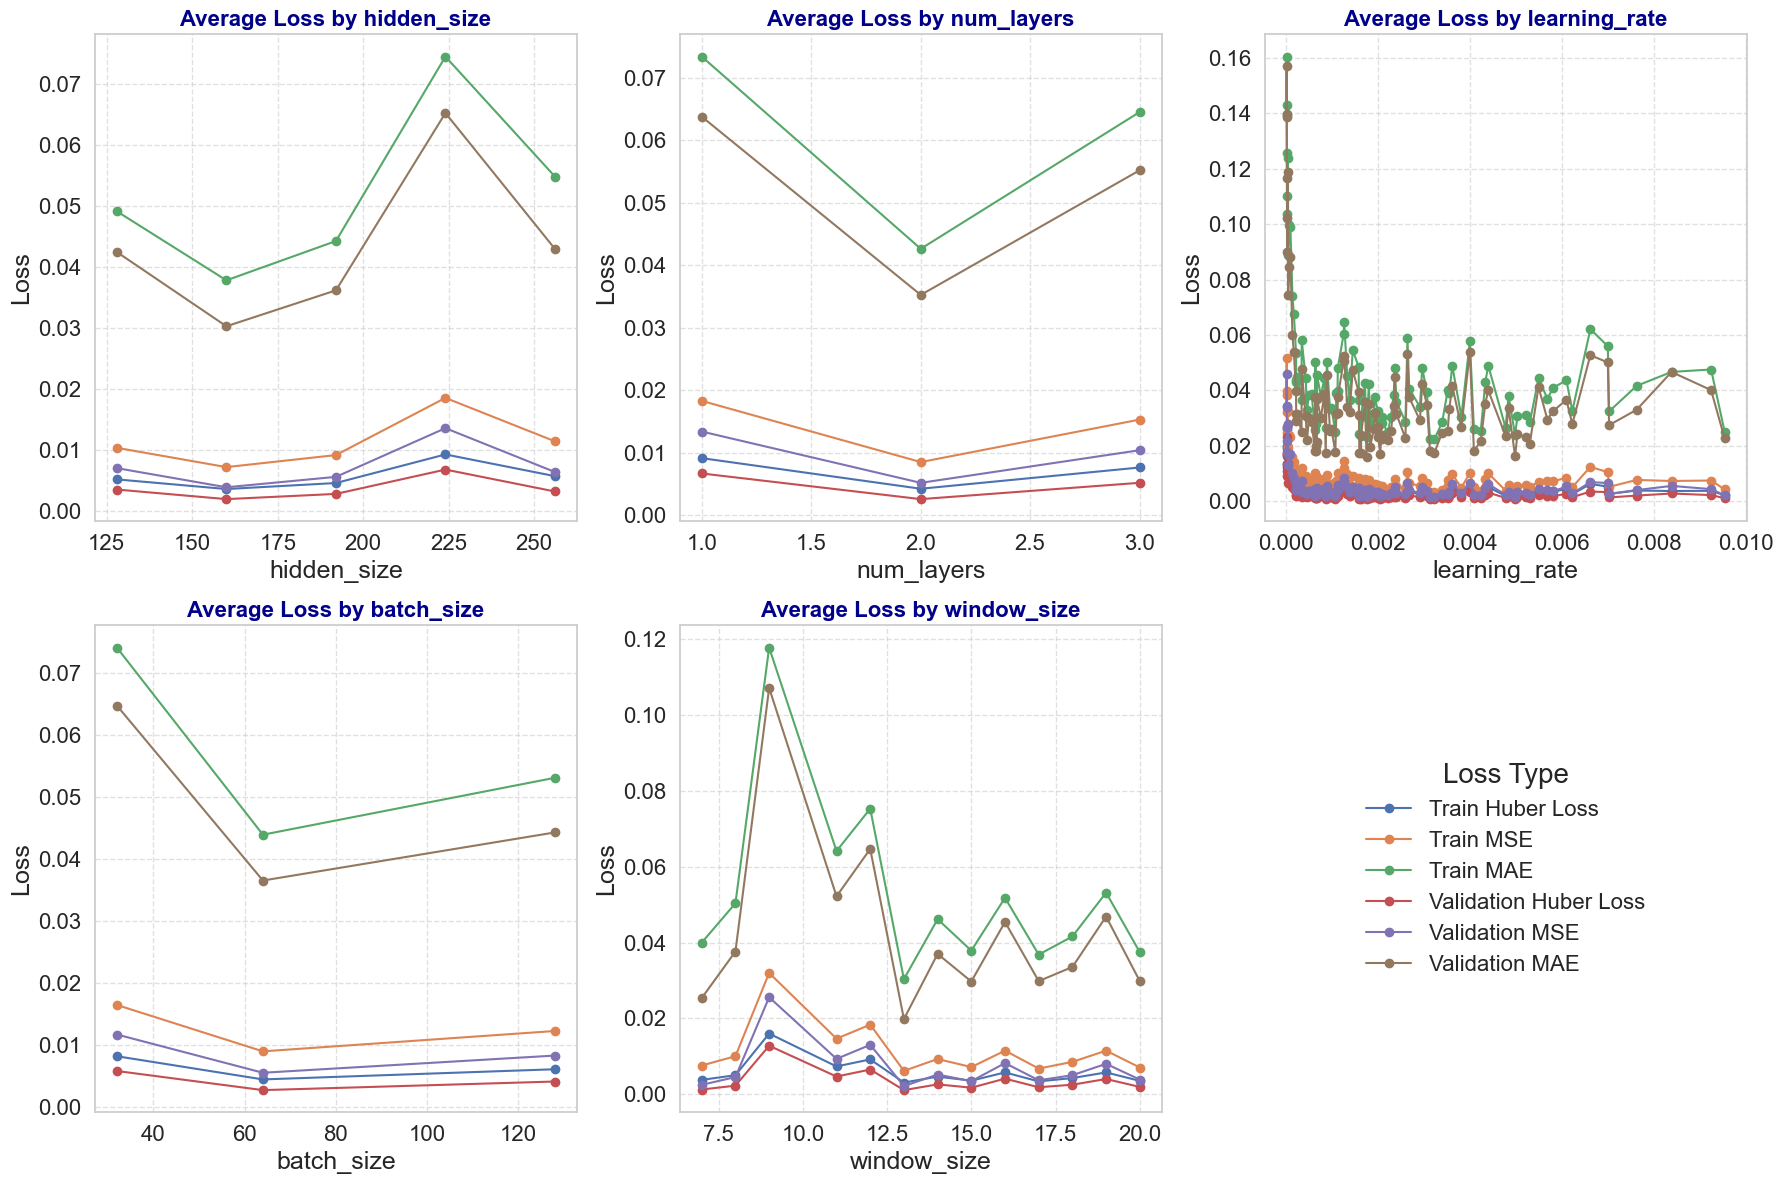

In [20]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"{output_dir}/metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_6796\410383499.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


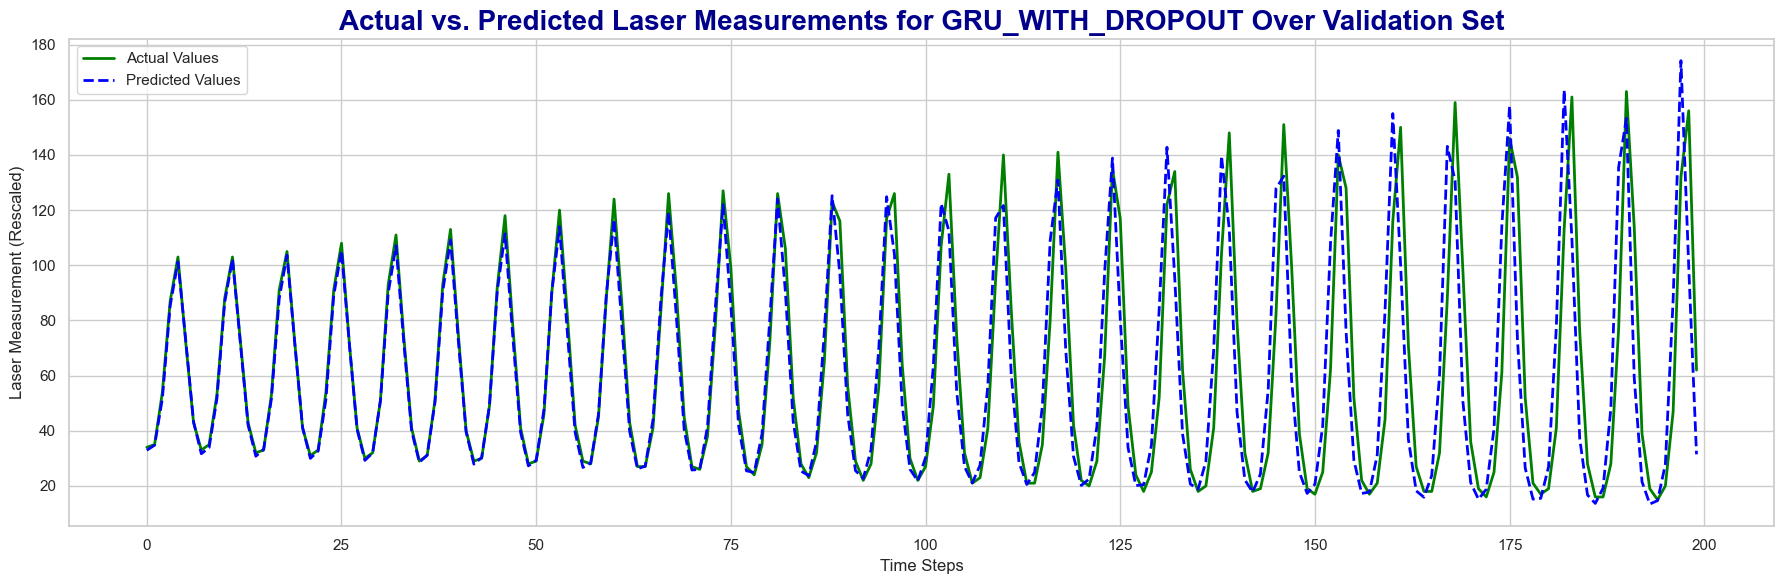

Metrics plot saved to ./Output/actual_vs_predicted_plot_GRU_WITH_DROPOUT_val.png


In [21]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained Gated recurrent units (GRUs) model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path, daateset_name=""):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title(f"Actual vs. Predicted Laser Measurements for {model_name} Over {daateset_name}", fontsize=20, weight='bold', color='darkblue')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_val.png", "Validation Set")

### Load the trained model

In [22]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = GRU(
        input_size=1,
        hidden_size=best_params['hidden_size'], 
        num_stacked_layers=best_params['num_layers'],
        dropout = best_params['dropout'] if 'dropout' in best_params else 0.0
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

# Update data loaders with the suggested batch size
window_size = best_params['window_size']
batch_size = best_params['batch_size']
train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)
test_loader, test_X, test_y = prepare_dataloader(test_dataset, window_size, batch_size=batch_size)

Best hyperparameters are: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.004083322193327303, 'batch_size': 128, 'window_size': 16, 'dropout': 0.1}


C:\Users\bar24\AppData\Local\Temp\ipykernel_6796\1173628409.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


## Evaluate the model

In [23]:
import torch.nn as nn

def evaluate_model(best_model, val_loader, dataset_name):
    """
    Evaluate the best model on given dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The given dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"For model: {model_name} - {dataset_name} Evaluation:")
    print(f"{dataset_name} MSE: {avg_mse}")
    print(f"{dataset_name} MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model(best_model, train_loader, "Training")
mse, mae = evaluate_model(best_model, val_loader, "Validation")
mse, mae = evaluate_model(best_model, test_loader, "Test")

For model: GRU_WITH_DROPOUT - Training Evaluation:
Training MSE: 0.001780873363072058
Training MAE: 0.010895705289570285
For model: GRU_WITH_DROPOUT - Validation Evaluation:
Validation MSE: 1.979535875598697e-05
Validation MAE: 0.0035025436614250015
For model: GRU_WITH_DROPOUT - Test Evaluation:
Test MSE: 0.0028641107443115247
Test MAE: 0.01537532555749235


C:\Users\bar24\AppData\Local\Temp\ipykernel_6796\1838245718.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(test_X[0], dtype=torch.float32).to(device)


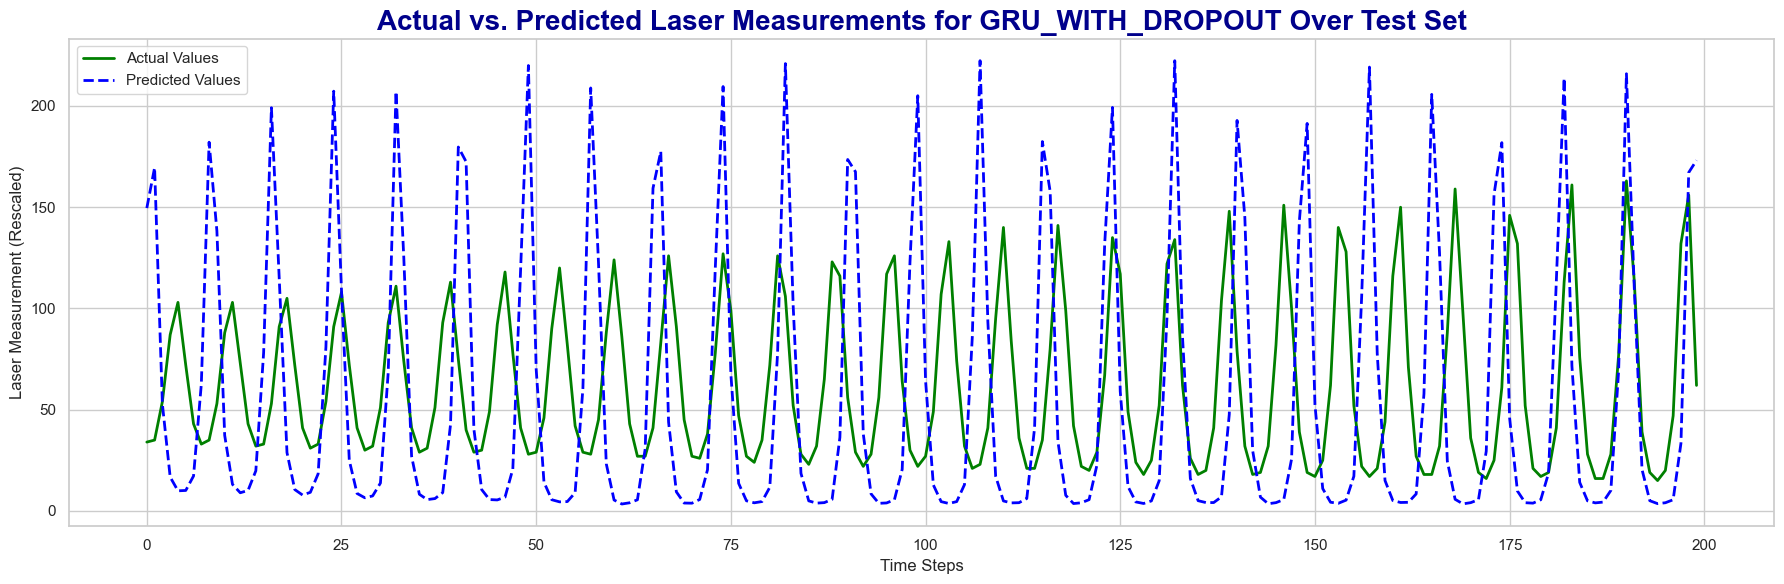

Metrics plot saved to ./Output/actual_vs_predicted_plot_GRU_WITH_DROPOUT_test.png


In [24]:
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(test_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_test.png", "Test Set")

## Plot for results

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files for RNN, LSTM, and GRU
rnn_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_RNN.csv")
lstm_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_LSTM.csv")
gru_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_GRU.csv")

# Add a column to identify the model
rnn_metrics["model"] = "RNN"
lstm_metrics["model"] = "LSTM"
gru_metrics["model"] = "GRU"

# Combine all metrics into a single DataFrame
all_metrics = pd.concat([rnn_metrics, lstm_metrics, gru_metrics], ignore_index=True)

# Define the parameters to plot
parameters_to_plot = ["hidden_size", "num_layers", "window_size", "batch_size"]

# Ensure all columns in parameters_to_plot are numeric and drop rows with NaN values
for param in parameters_to_plot:
    if param in all_metrics.columns:
        all_metrics[param] = pd.to_numeric(all_metrics[param], errors="coerce")
all_metrics = all_metrics.dropna(subset=parameters_to_plot)

# Define the loss functions to plot
loss_functions = {
    "MSE": ["train_MSE", "val_MSE"],
    "MAE": ["train_MAE", "val_MAE"]
}

# Define a mapping for paper-friendly parameter names
parameter_name_mapping = {
    "hidden_size": "Hidden Size",
    "num_layers": "Number of Layers",
    "window_size": "Window Size",
    "batch_size": "Batch Size"
}

# Replace parameter names in the parameters_to_plot list
parameters_to_plot = [parameter_name_mapping[param] for param in parameters_to_plot]

# Define colors for models
model_colors = {
    "RNN": ("blue", "darkblue"),
    "LSTM": ("mediumpurple", "purple"),
    "GRU": ("red", "darkred")
}

# Function to plot metrics for each loss function
# Function to plot metrics for each loss function
def plot_loss_metrics(metrics_df, loss_type, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses for train and validation.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        loss_type (str): The loss type to plot (e.g., "MSE", "MAE").
        parameters (list): List of parameters to plot (e.g., ['Hidden Size', 'Number of Layers', 'Window Size', 'Batch Size']).
        save_path (str): Path to save the plot.
    """
    loss_columns = loss_functions[loss_type]
    num_params = len(parameters)
    ncols = 2  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Define markers for train and validation sets
    markers = {"train": "o", "val": "s"}  # Circle for train, square for validation
    linestyles = {"train": "-", "val": ":"}  # Solid for train, dotted for validation

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        original_param = [key for key, value in parameter_name_mapping.items() if value == parameter][0]
        if original_param not in metrics_df.columns:
            continue  # Skip if the parameter is not in the DataFrame
        for model_name, model_df in metrics_df.groupby("model"):
            # Ensure the parameter column is numeric
            model_df[original_param] = pd.to_numeric(model_df[original_param], errors="coerce")
            model_df = model_df.dropna(subset=[original_param])  # Drop rows with NaN in the parameter column
            
            grouped = model_df.groupby(original_param).mean(numeric_only=True)  # Group by the parameter and calculate averages
            for loss_col, color in zip(loss_columns, model_colors[model_name]):
                if loss_col in grouped.columns:
                    # Determine marker type based on whether it's train or validation
                    marker_type = markers["train"] if "train" in loss_col else markers["val"]
                    linestyle_type = linestyles["train"] if "train" in loss_col else linestyles["val"]

                    label = f"{model_name} - {'Train' if 'train' in loss_col else 'Validation'}"
                    ax.plot(grouped.index, grouped[loss_col], label=label, color=color, marker=marker_type, linestyle=linestyle_type, linewidth=2.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18, color='royalblue', weight='bold')
        ax.set_ylabel(f"{loss_type} Loss", fontsize=18, color='royalblue', weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f"{loss_type} Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

        # Set x-axis ticks to the unique values of the parameter
        unique_values = sorted(metrics_df[original_param].unique())
        ax.set_xticks(unique_values)
        ax.set_xticklabels([str(int(val)) if val.is_integer() else f"{val:.2f}" for val in unique_values], rotation=45)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Add a legend to the right of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=22, title="Model and Loss Type", title_fontsize=26)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
    plt.suptitle(f"{loss_type} Loss Metrics Across Models", fontsize=26, weight='bold')
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Generate plots for MSE and MAE
plot_loss_metrics(all_metrics, "MSE", parameters_to_plot, f"{output_dir}/MSE_loss_metrics_across_models.png")
plot_loss_metrics(all_metrics, "MAE", parameters_to_plot, f"{output_dir}/MAE_loss_metrics_across_models.png")